In [45]:
import os
os.getcwd()
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, pearsonr
from statsmodels.miscmodels.ordinal_model import OrderedModel

survey = pd.read_excel("survey.xlsx")
survey=survey[survey['included']==1]

In [47]:
columns_to_check_time = [
       'time spend on all social media apps actual', 'Instagram actual',
       'TikTok actual', 'FB actual', 'whatsApp actual', 'LinkedIn actual',
       'Twitter actual', 'Youtube actual', 'Snapchat actual', 'Threads actual',
       'Pinterest actual', 'other actual']

# Calculate Z-score for the selected columns
z_scores_time = np.abs(stats.zscore(survey[columns_to_check_time]))

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Create a mask to filter out rows with outliers in any of the selected columns
outlier_mask_time = (z_scores_time > threshold).any(axis=1)

# Filter out rows with outliers
df_cleaned = survey[~outlier_mask_time]
df_cleaned = df_cleaned.reset_index(drop=True)

# Initialize the 'outliers' column to 0
survey['outliers'] = 0

# Update the 'outliers' column in the original DataFrame based on the filtered DataFrame's outlier_mask
survey.loc[survey.index, 'outliers'] = np.where(outlier_mask_time, 1, 0)

# print the number of outliers detected
num_outliers = outlier_mask_time.sum()
print(f'Number of outliers detected: {num_outliers}')

# Display the DataFrame to verify
print(survey.head())

Number of outliers detected: 76
   included   IDkoda  not equal            t_insert              t_edit  \
5         1  487grfa          0 2024-05-29 10:13:01 2024-05-29 10:21:04   
6         1  731gkam          0 2024-05-29 10:13:02 2024-05-29 10:20:05   
7         1   705fml          0 2024-05-29 10:13:03 2024-05-29 10:22:24   
8         1  67bemf5          0 2024-05-29 10:13:04 2024-05-29 10:22:02   
9         1  001mgan          1 2024-05-29 10:13:05 2024-05-29 10:23:43   

   status  SEX  AGE   Q2   Q3  ...  FB actual  whatsApp actual  \
5       6    2   23  0.0  0.0  ...         23                0   
6       6    2   22  0.0  0.0  ...          0                0   
7       6    2   22  0.0  0.0  ...         21                0   
8       6    1   22  0.0  0.0  ...         57                0   
9       6    2   22  0.0  0.0  ...         26                4   

   LinkedIn actual  Twitter actual  Youtube actual  Snapchat actual  \
5                0               0               

In [260]:
# transforming risk taking outcomes into just one variable for lotteries, to see if we find some siginifcant resutls
# Create a risk-taking variable
lotteries = ['Q2','Q3','Q4','Q5']
def classify_risk_taking(row):
    num_risky = sum(row[col] == 1 for col in lotteries)
    num_safe = sum(row[col] == 0 for col in lotteries)
    if num_risky > num_safe:
        return 1  # Risk-taking
    elif num_safe > num_risky:
        return 2   # Risk-averse
    else:
        return 0   # Neutral

survey['risk_taking'] = survey.apply(classify_risk_taking, axis=1)

survey['sum_r'] = survey[lotteries].sum(axis=1)

# Risk-taking framing effect from scenarios 
scenarios_columns = [ 'Q8', 'Q9', 'Q7a', 'Q7b']
def classify_framing(row):
    num_risky = sum(row[col] == 1 for col in scenarios_columns)
    num_safe = sum(row[col] == 0 for col in scenarios_columns)
    if num_risky == 2:
        return 0  
    elif num_safe == 2:
        return 0   
    else:
        return 1   
    
    
survey['framing'] = survey.apply(classify_framing, axis=1)

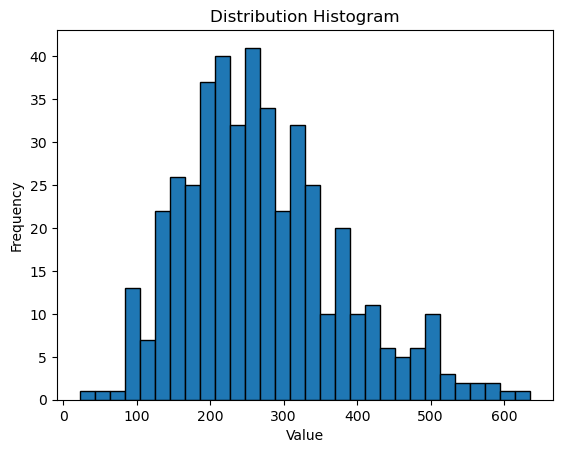

Chi-square statistic: 9.858882991080096, p-value: 0.042873066537729224


In [50]:
# Create the histogram
plt.hist(survey['time spend on all social media apps actual'], bins=30, edgecolor='black')
plt.title('Distribution Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Define percentiles
tercile1 = survey['time spend on all social media apps actual'].quantile(0.33)
tercile2 = survey['time spend on all social media apps actual'].quantile(0.66)

# Create the new variable
def categorize_usage(minutes):
    if minutes <= tercile1:
        return 0
    elif minutes <= tercile2:
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")


In [52]:
# Create contingency table for framing risk-taking and social media usage
contingency_framing_table = pd.crosstab(survey['framing'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_framing_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")

Chi-square statistic: 2.990143490117569, p-value: 0.2242325165783362


In [256]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['social_media_group', 'SEX', 'AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_TERCILE = OrderedModel(y, X, distr='logit')
result_TERCILE = model_TERCILE.fit(method='bfgs')

# Display the summary
print(result_TERCILE.summary())

Optimization terminated successfully.
         Current function value: 0.995299
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -445.89
Model:                   OrderedModel   AIC:                             901.8
Method:            Maximum Likelihood   BIC:                             922.3
Date:                Wed, 14 Aug 2024                                         
Time:                        15:25:27                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [55]:
# Create the new variable
def categorize_usage(minutes):
    if minutes <= 200: #190,150
        return 0
    elif minutes <= 270: #270
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")



Chi-square statistic: 12.862075846105958, p-value: 0.011969753167733124


In [84]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X_ordered = survey[['social_media_group', 'SEX','AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_ordered = OrderedModel(y, X_ordered, distr='logit')
result_ordered = model_ordered.fit(method='bfgs')

# Display the summary
print(result_ordered.summary())

Optimization terminated successfully.
         Current function value: 0.995299
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -445.89
Model:                   OrderedModel   AIC:                             901.8
Method:            Maximum Likelihood   BIC:                             922.3
Date:                Thu, 08 Aug 2024                                         
Time:                        11:23:32                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [253]:
# Prepare data
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['time spend on all social media apps actual', 'SEX','AGE']] #WITH SOCIAL_MEDIA_GROUP BETTER P VALUES AND COEFF
y = survey['risk_taking']

# Add constant term for the intercept
X = sm.add_constant(X)

# Fit multinomial logistic regression model
mnlogit_model = sm.MNLogit(y, X).fit()
print(mnlogit_model.summary())

Optimization terminated successfully.
         Current function value: 0.990214
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            risk_taking   No. Observations:                  448
Model:                        MNLogit   Df Residuals:                      440
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:                 0.02145
Time:                        15:11:02   Log-Likelihood:                -443.62
converged:                       True   LL-Null:                       -453.34
Covariance Type:            nonrobust   LLR p-value:                  0.003472
                             risk_taking=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

In [257]:
import numpy as np
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
import scipy.stats

# Assuming your current model is stored in 'result_sm'
# and your data is in a DataFrame called 'survey'

# Create a null model by always predicting the most common class
y = survey['risk_taking']
most_common_class = y.mode()[0]
y_pred_null = pd.Series([most_common_class] * len(y), index=y.index)

# Calculate log-likelihood for the null model
prob_most_common = (y == most_common_class).mean()
ll_null = len(y) * np.log(prob_most_common)

# Extract log-likelihood for the full model
ll_full = result_sm.llf

print(f"Log-likelihood null model: {ll_null:.4f}")
print(f"Log-likelihood full model: {ll_full:.4f}")

# Likelihood Ratio Test
lr_statistic = -2 * (ll_null - ll_full)
df = len(result_sm.params) - 1  # Subtracting 1 for the implicit intercept in the null model
p_value = scipy.stats.chi2.sf(lr_statistic, df)

print(f"Likelihood Ratio Test:")
print(f"LR test statistic: {lr_statistic:.4f}")
print(f"Degrees of freedom: {df}")
print(f"p-value: {p_value:.4f}")

# McFadden's R-squared
mcfadden_r2 = 1 - (ll_full / ll_null)
print(f"McFadden's R-squared: {mcfadden_r2:.4f}")

# Calculate AIC and BIC for the full model
aic_full = result_sm.aic
bic_full = result_sm.bic

print(f"\nFull Model:")
print(f"AIC: {aic_full:.4f}")
print(f"BIC: {bic_full:.4f}")

# Calculate predicted probabilities for the full model
# Use the same variables and order as in the original model
X_pred = survey[result_sm.model.exog_names]
probs = result_sm.predict(X_pred)

# Convert probabilities to class predictions
y_pred_full = probs.idxmax(axis=1)

# Calculate accuracy for both models
accuracy_null = (y == y_pred_null).mean()
accuracy_full = (y == y_pred_full).mean()

print(f"\nNull Model Accuracy (Baseline): {accuracy_null:.4f}")
print(f"Full Model Accuracy: {accuracy_full:.4f}")
print(f"Improvement over baseline: {accuracy_full - accuracy_null:.4f}")

Log-likelihood null model: -310.5299
Log-likelihood full model: -472.8270
Likelihood Ratio Test:
LR test statistic: -324.5942
Degrees of freedom: 5
p-value: 1.0000
McFadden's R-squared: -0.5226

Full Model:
AIC: 957.6541
BIC: 982.2828


KeyError: "['0/1', '1/2'] not in index"

In [258]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
survey['SA'] = survey['time spend on all social media apps actual'] * survey['AGE']
X_continuous = survey[['time spend on all social media apps actual', 'SEX','AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_continuous = OrderedModel(y, X_continuous, distr='logit')
result_continuous = model_continuous.fit(method='bfgs')

# Display the summary
print(result_continuous.summary())


Optimization terminated successfully.
         Current function value: 1.003647
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -449.63
Model:                   OrderedModel   AIC:                             909.3
Method:            Maximum Likelihood   BIC:                             929.8
Date:                Wed, 14 Aug 2024                                         
Time:                        15:26:23                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
------

In [263]:
import statsmodels.api as sm

# Define the predictors and the dependent variable
X_continuous = survey[['time spend on all social media apps actual', 'SEX', 'AGE']]
y = survey['sum_r']

# Add a constant to the predictors (this adds the intercept to the model)
X_continuous = sm.add_constant(X_continuous)

# Fit the Poisson regression model
model_poisson = sm.GLM(y, X_continuous, family=sm.families.Poisson()).fit()

# Display the summary
print(model_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sum_r   No. Observations:                  448
Model:                            GLM   Df Residuals:                      444
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -651.51
Date:                Wed, 14 Aug 2024   Deviance:                       303.60
Time:                        15:36:47   Pearson chi2:                     223.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01859
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [264]:
# Convert 'SEX' to categorical codes if it's not already
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['sm'] = survey['social_media_group'] * survey['AGE']
survey['SA'] = survey['SEX'] * survey['TikTok actual']
# Prepare the features (X) and the target (y)
X = survey[['social_media_group', 'SEX','SA']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_inter = OrderedModel(y, X, distr='logit')
result_inter = model_inter.fit(method='bfgs')

# Display the summary
print(result_inter.summary())

Optimization terminated successfully.
         Current function value: 0.994273
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -445.43
Model:                   OrderedModel   AIC:                             900.9
Method:            Maximum Likelihood   BIC:                             921.4
Date:                Wed, 14 Aug 2024                                         
Time:                        15:37:44                                         
No. Observations:                 448                                         
Df Residuals:                     443                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [103]:
# Compare models using AIC and BIC
print(f"Ordered Model AIC: {result_ordered.aic}, BIC: {result_ordered.bic}")
print(f"Continuous Model AIC: {result_continuous.aic}, BIC: {result_continuous.bic}")

# Log-Likelihood comparison
print(f"Ordered Model Log-Likelihood: {result_ordered.llf}")
print(f"Continuous Model Log-Likelihood: {result_continuous.llf}")

# Pseudo R-squared calculation
def pseudo_r2(llf, llf_null):
    return 1 - (llf / llf_null)

# Use the log-likelihood of the null model for comparison
llf_null = np.log(y.value_counts().max() / len(y)) * len(y)  # Log-likelihood of a null model with the most frequent class
pseudo_r2_ordered = pseudo_r2(result_ordered.llf, llf_null)
pseudo_r2_continuous = pseudo_r2(result_continuous.llf, llf_null)

print(f"Ordered Model Pseudo R-squared: {pseudo_r2_ordered}")
print(f"Continuous Model Pseudo R-squared: {pseudo_r2_continuous}")

# Train-test split for accuracy comparison
X_ordered_train, X_ordered_test, y_train, y_test = train_test_split(X_ordered, y, test_size=0.2, random_state=42)
X_continuous_train, X_continuous_test, y_train, y_test = train_test_split(X_continuous, y, test_size=0.2, random_state=42)

# Fit models for accuracy evaluation
model_ordered_cv = OrderedModel(y_train, X_ordered_train, distr='logit').fit(method='bfgs', disp=False)
model_continuous_cv = OrderedModel(y_train, X_continuous_train, distr='logit').fit(method='bfgs', disp=False)

# Predict and convert probabilities to class labels
def predict_classes(model, X):
    # Get predicted probabilities
    probs = model.predict(X)
    # Convert probabilities to class labels
    return np.argmax(probs, axis=1)

# Predict and calculate accuracy
y_pred_ordered = predict_classes(model_ordered_cv, X_ordered_test)
y_pred_continuous = predict_classes(model_continuous_cv, X_continuous_test)
accuracy_ordered = accuracy_score(y_test, y_pred_ordered)
accuracy_continuous = accuracy_score(y_test, y_pred_continuous)

print(f"Ordered Model Accuracy: {accuracy_ordered}")
print(f"Continuous Model Accuracy: {accuracy_continuous}")

Ordered Model AIC: 901.7878815804643, BIC: 922.3118477425392
Continuous Model AIC: 909.2679949371171, BIC: 929.791961099192
Ordered Model Log-Likelihood: -445.89394079023214
Continuous Model Log-Likelihood: -449.63399746855856
Ordered Model Pseudo R-squared: -0.435912895402913
Continuous Model Pseudo R-squared: -0.447957005274487
Ordered Model Accuracy: 0.4222222222222222
Continuous Model Accuracy: 0.4666666666666667


In [ ]:
# Convert 'SEX' to categorical codes 
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['gender_sm'] = survey['SEX'] * survey['social_media_group']
survey['SA'] = survey['SEX'] * survey['risk_taking']
# Prepare the features (X) and the target (y)
X = survey[['risk_taking', 'SEX','AGE','framing']]
y = survey['social_media_group']

# Fit the ordinal logistic regression model
model_sm = OrderedModel(y, X, distr='logit')
result_sm = model_sm.fit(method='bfgs')

# Display the summary
print(result_sm.summary())

Optimization terminated successfully.
         Current function value: 1.055418
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:     social_media_group   Log-Likelihood:                -472.83
Model:                   OrderedModel   AIC:                             957.7
Method:            Maximum Likelihood   BIC:                             982.3
Date:                Sat, 10 Aug 2024                                         
Time:                        09:53:30                                         
No. Observations:                 448                                         
Df Residuals:                     442                                         
Df Model:                           4                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [186]:
# Assuming the predictions and accuracy values from the above models
accuracy_dict = {
    "Ordinal Logistic Regression": accuracy_ordinal,
    "Generalized Ordinal Logistic Regression": accuracy_gologit,
    "Multinomial Logistic Regression": accuracy_multinomial,

}

# Print the comparison summary
print("\nComparison Summary:")
for model_name, accuracy in accuracy_dict.items():
    print(f"{model_name} Accuracy: {accuracy}")



Comparison Summary:
Ordinal Logistic Regression Accuracy: 0.515625
Generalized Ordinal Logistic Regression Accuracy: 0.140625
Multinomial Logistic Regression Accuracy: 0.140625
CatBoost Accuracy: 0.546875
Ordinal Decision Tree Accuracy: 0.5334821428571429
Neural Network Accuracy: 0.5


In [239]:
# Social media as dependant in lienar regression


X = survey[['risk_taking', 'SEX','AGE']]
y = survey['time spend on all social media apps actual']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                                        OLS Regression Results                                        
Dep. Variable:     time spend on all social media apps actual   R-squared:                       0.016
Model:                                                    OLS   Adj. R-squared:                  0.010
Method:                                         Least Squares   F-statistic:                     2.462
Date:                                        Tue, 13 Aug 2024   Prob (F-statistic):             0.0620
Time:                                                11:42:03   Log-Likelihood:                -2723.8
No. Observations:                                         448   AIC:                             5456.
Df Residuals:                                             444   BIC:                             5472.
Df Model:                                                   3                                         
Covariance Type:                                    nonrobust            

In [235]:
# Convert 'SEX' to categorical codes 
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['gender_sm'] = survey['SEX'] * survey['social_media_group']
survey['SA'] = survey['SEX'] * survey['risk_taking']
# Prepare the features (X) and the target (y)
X = survey[['risk_taking', 'SEX','AGE','framing']]
y = survey['social_media_group']

# Fit the ordinal logistic regression model
model_sm = OrderedModel(y, X, distr='logit')
result_sm = model_sm.fit(method='bfgs')

# Display the summary
print(result_sm.summary())

Optimization terminated successfully.
         Current function value: 1.055418
         Iterations: 29
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:     social_media_group   Log-Likelihood:                -472.83
Model:                   OrderedModel   AIC:                             957.7
Method:            Maximum Likelihood   BIC:                             982.3
Date:                Tue, 13 Aug 2024                                         
Time:                        11:40:04                                         
No. Observations:                 448                                         
Df Residuals:                     442                                         
Df Model:                           4                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [237]:
import numpy as np

# Calculate log-likelihood of "most common class" model
most_common_class = y.mode()[0]
null_probs = np.zeros((len(y), y.nunique()))
null_probs[:, most_common_class] = 1
ll_null = np.log(null_probs[np.arange(len(y)), y]).sum()

# Compare to your model's log-likelihood
ll_full = result_sm.llf

# Calculate likelihood ratio test
lr_statistic = -2 * (ll_null - ll_full)
df = len(result_sm.params) - 1  # Subtracting 1 for the implicit intercept in the null model
p_value = scipy.stats.chi2.sf(lr_statistic, df)

print(f"LR test statistic: {lr_statistic}")
print(f"p-value: {p_value}")

# Recalculate McFadden's R-squared
mcfadden_r2 = 1 - (ll_full / ll_null)
print(f"McFadden's R-squared: {mcfadden_r2}")

LR test statistic: inf
p-value: 0.0
McFadden's R-squared: 1.0


/var/folders/jh/x3pzkf253nz6__d6tfg4p4200000gn/T/ipykernel_98034/2641258256.py:7: RuntimeWarning: divide by zero encountered in log
  ll_null = np.log(null_probs[np.arange(len(y)), y]).sum()


In [238]:
baseline_accuracy = y.value_counts().max() / len(y)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Improvement: {accuracy - baseline_accuracy:.4f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

Baseline Accuracy: 0.4286
Model Accuracy: 0.4286
Improvement: 0.0000
Confusion Matrix:
[[  0   0 122]
 [  0   0 134]
 [  0   0 192]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       134
           2       0.43      1.00      0.60       192

    accuracy                           0.43       448
   macro avg       0.14      0.33      0.20       448
weighted avg       0.18      0.43      0.26       448



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model is performing exactly the same as the baseline model, which simply predicts the most common class every time.